In [1]:
from netin.models import DPAHModel

In [2]:
from multiprocessing import Pool, cpu_count
from typing import Dict, List, Set
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import networkx as nx
from src.seed import (seed_degree, 
    seed_polarized, 
    seed_random, 
    seed_polarized_centrality_mixed, 
    seed_polarized_centrality, 
    seed_polarized_degree, 
    seed_centrality_mixed, 
    seed_centrality, 
    seed_influence_maximization
)


from evaluation_fixed_seed_seq import evaluate_all_seeds_incremental

In [3]:
N = 450 # Number of total nodes
f_m = 0.45 # Fraction of minority nodes
h = 0.25 # Homophilic
d = 0.09 # desity of the graph  
plo = 2.1
#final number of edges will be: e = d * n (n-1)

In [4]:
dpa_model = DPAHModel(N=N, f_m=f_m, d=d, plo_M=plo, plo_m=plo, h_M=h, h_m=h)
dpa_graph = dpa_model.simulate()

In [5]:
G = dpa_graph.to_nxgraph() # This creates a copy of the graph

for node, attr in G.nodes(data=True):
    attr['color'] = attr.pop('minority')

for node in G.nodes():
        in_degree = G.in_degree(node)
        for neighbor in G.successors(node):
            G[node][neighbor]["weight"] = 1 / (2 * in_degree) if in_degree > 0 else 1

In [6]:
seed_size = G.number_of_nodes() // 20
print(f"Seed size: {seed_size}")
max_iter = 1000
k_values = np.linspace(1, seed_size, 5, dtype=int) 

Seed size: 22


In [7]:
seed_functions = {
        "Random": seed_random(G, seed_size),
        "Degree": seed_degree(G, seed_size),
        "Centrality": seed_centrality(G, seed_size),
        "Centrality Mixed": seed_centrality_mixed(G, seed_size),
        "Polarized": seed_polarized(G, seed_size, 0),
        "Polarized Degree": seed_polarized_degree(G, seed_size, 0),
        "Polarized Centrality": seed_polarized_centrality(G, seed_size, 0),
        "Polarized Centrality Mixed": seed_polarized_centrality_mixed(G, seed_size, 0),
    }

# Run the evaluation
all_results_df = evaluate_all_seeds_incremental(
    G, 
    seed_functions, 
    k_values,
    max_iter=max_iter,
    name="netin_test",
    verbose=False
)

# Save results
all_results_df.to_csv(
    f"results/test/results_test_netin_{N}_nodes_{h}_hvalue_{d}_density_incremental.csv",
    index=False
)

Running evaluation for seed function: Random


100%|██████████| 450/450 [00:00<00:00, 522.79it/s]


Running evaluation for seed function: Degree


100%|██████████| 450/450 [00:00<00:00, 2520.70it/s]


Running evaluation for seed function: Centrality


100%|██████████| 450/450 [00:00<00:00, 2449.65it/s]


Running evaluation for seed function: Centrality Mixed


100%|██████████| 450/450 [00:00<00:00, 2646.79it/s]


Running evaluation for seed function: Polarized


100%|██████████| 450/450 [00:00<00:00, 2454.12it/s]


Running evaluation for seed function: Polarized Degree


Evaluating nodes:  77%|███████▋  | 329/428 [00:28<00:08, 11.31it/s]

In [ ]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.pyplot as plt

def plot_incremental_results(df, metric="Avg Activated Nodes"):
    """
    Plot results from incremental evaluation DataFrame, excluding Original Graph
    and organizing seed functions in pairs.
    
    Args:
        df (pd.DataFrame): DataFrame containing the results
        metric (str): Metric to plot (default: "Avg Activated Nodes")
    """
    # Filter out "Original Graph"
    df_filtered = df[df['Graph Modification'] != "Original Graph"]
    
    # Define seed function pairs and their order
    seed_pairs = [
        ("Random", "Polarized"),
        ("Degree", "Polarized Degree"),
        ("Centrality", "Polarized Centrality"),
        ("Centrality Mixed", "Polarized Centrality Mixed")
    ]
    
    # Get unique seed functions available in the data
    available_seeds = set(df_filtered['Seed Function'].unique())
    
    # Filter pairs to only include available seed functions
    active_pairs = []
    for pair in seed_pairs:
        if pair[0] in available_seeds and pair[1] in available_seeds:
            active_pairs.append(pair)
        elif pair[0] in available_seeds:
            active_pairs.append((pair[0], None))
        elif pair[1] in available_seeds:
            active_pairs.append((pair[1], None))
    
    # Set up the plotting grid
    sns.set(style="whitegrid")
    rows = len(active_pairs)
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
    
    # Make axes 2D if it isn't already
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Get k values
    k_values = sorted(df_filtered['K Value'].unique())
    
    # Create plots for each seed function pair
    for i, (seed1, seed2) in enumerate(active_pairs):
        # Plot first seed function
        seed_df = df_filtered[df_filtered['Seed Function'] == seed1]
        pivot_table = seed_df.pivot_table(
            index='K Value',
            columns='Graph Modification',
            values=metric
        )
        pivot_table = pivot_table.reindex(k_values)
        
        # Plot on left subplot
        ax = axes[i, 0]
        for graph_modification in pivot_table.columns:
            if graph_modification in ["Custom", "Custom V2", "Custom V3"]:
                pivot_table[graph_modification].plot(
                    ax=ax,
                    marker='o',
                    linewidth=3,
                    label=graph_modification
                )
            else:
                pivot_table[graph_modification].plot(
                    ax=ax,
                    marker='o',
                    linewidth=1,
                    label=graph_modification
                )
        
        ax.set_title(f"Seed Function: {seed1}")
        ax.set_xlabel("K Value")
        ax.set_ylabel(metric)
        ax.set_xticks(k_values)
        ax.legend(title="Graph Modification", bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Plot second seed function if it exists
        if seed2:
            seed_df = df_filtered[df_filtered['Seed Function'] == seed2]
            pivot_table = seed_df.pivot_table(
                index='K Value',
                columns='Graph Modification',
                values=metric
            )
            pivot_table = pivot_table.reindex(k_values)
            
            # Plot on right subplot
            ax = axes[i, 1]
            for graph_modification in pivot_table.columns:
                if graph_modification in ["Custom", "Custom V2", "Custom V3"]:
                    pivot_table[graph_modification].plot(
                        ax=ax,
                        marker='o',
                        linewidth=3,
                        label=graph_modification
                    )
                else:
                    pivot_table[graph_modification].plot(
                        ax=ax,
                        marker='o',
                        linewidth=1,
                        label=graph_modification
                    )
            
            ax.set_title(f"Seed Function: {seed2}")
            ax.set_xlabel("K Value")
            ax.set_ylabel(metric)
            ax.set_xticks(k_values)
            ax.legend(title="Graph Modification", bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, linestyle='--', alpha=0.7)
        else:
            # Remove the unused subplot
            fig.delaxes(axes[i, 1])
    
    # Adjust layout
    plt.tight_layout()
    
    return fig



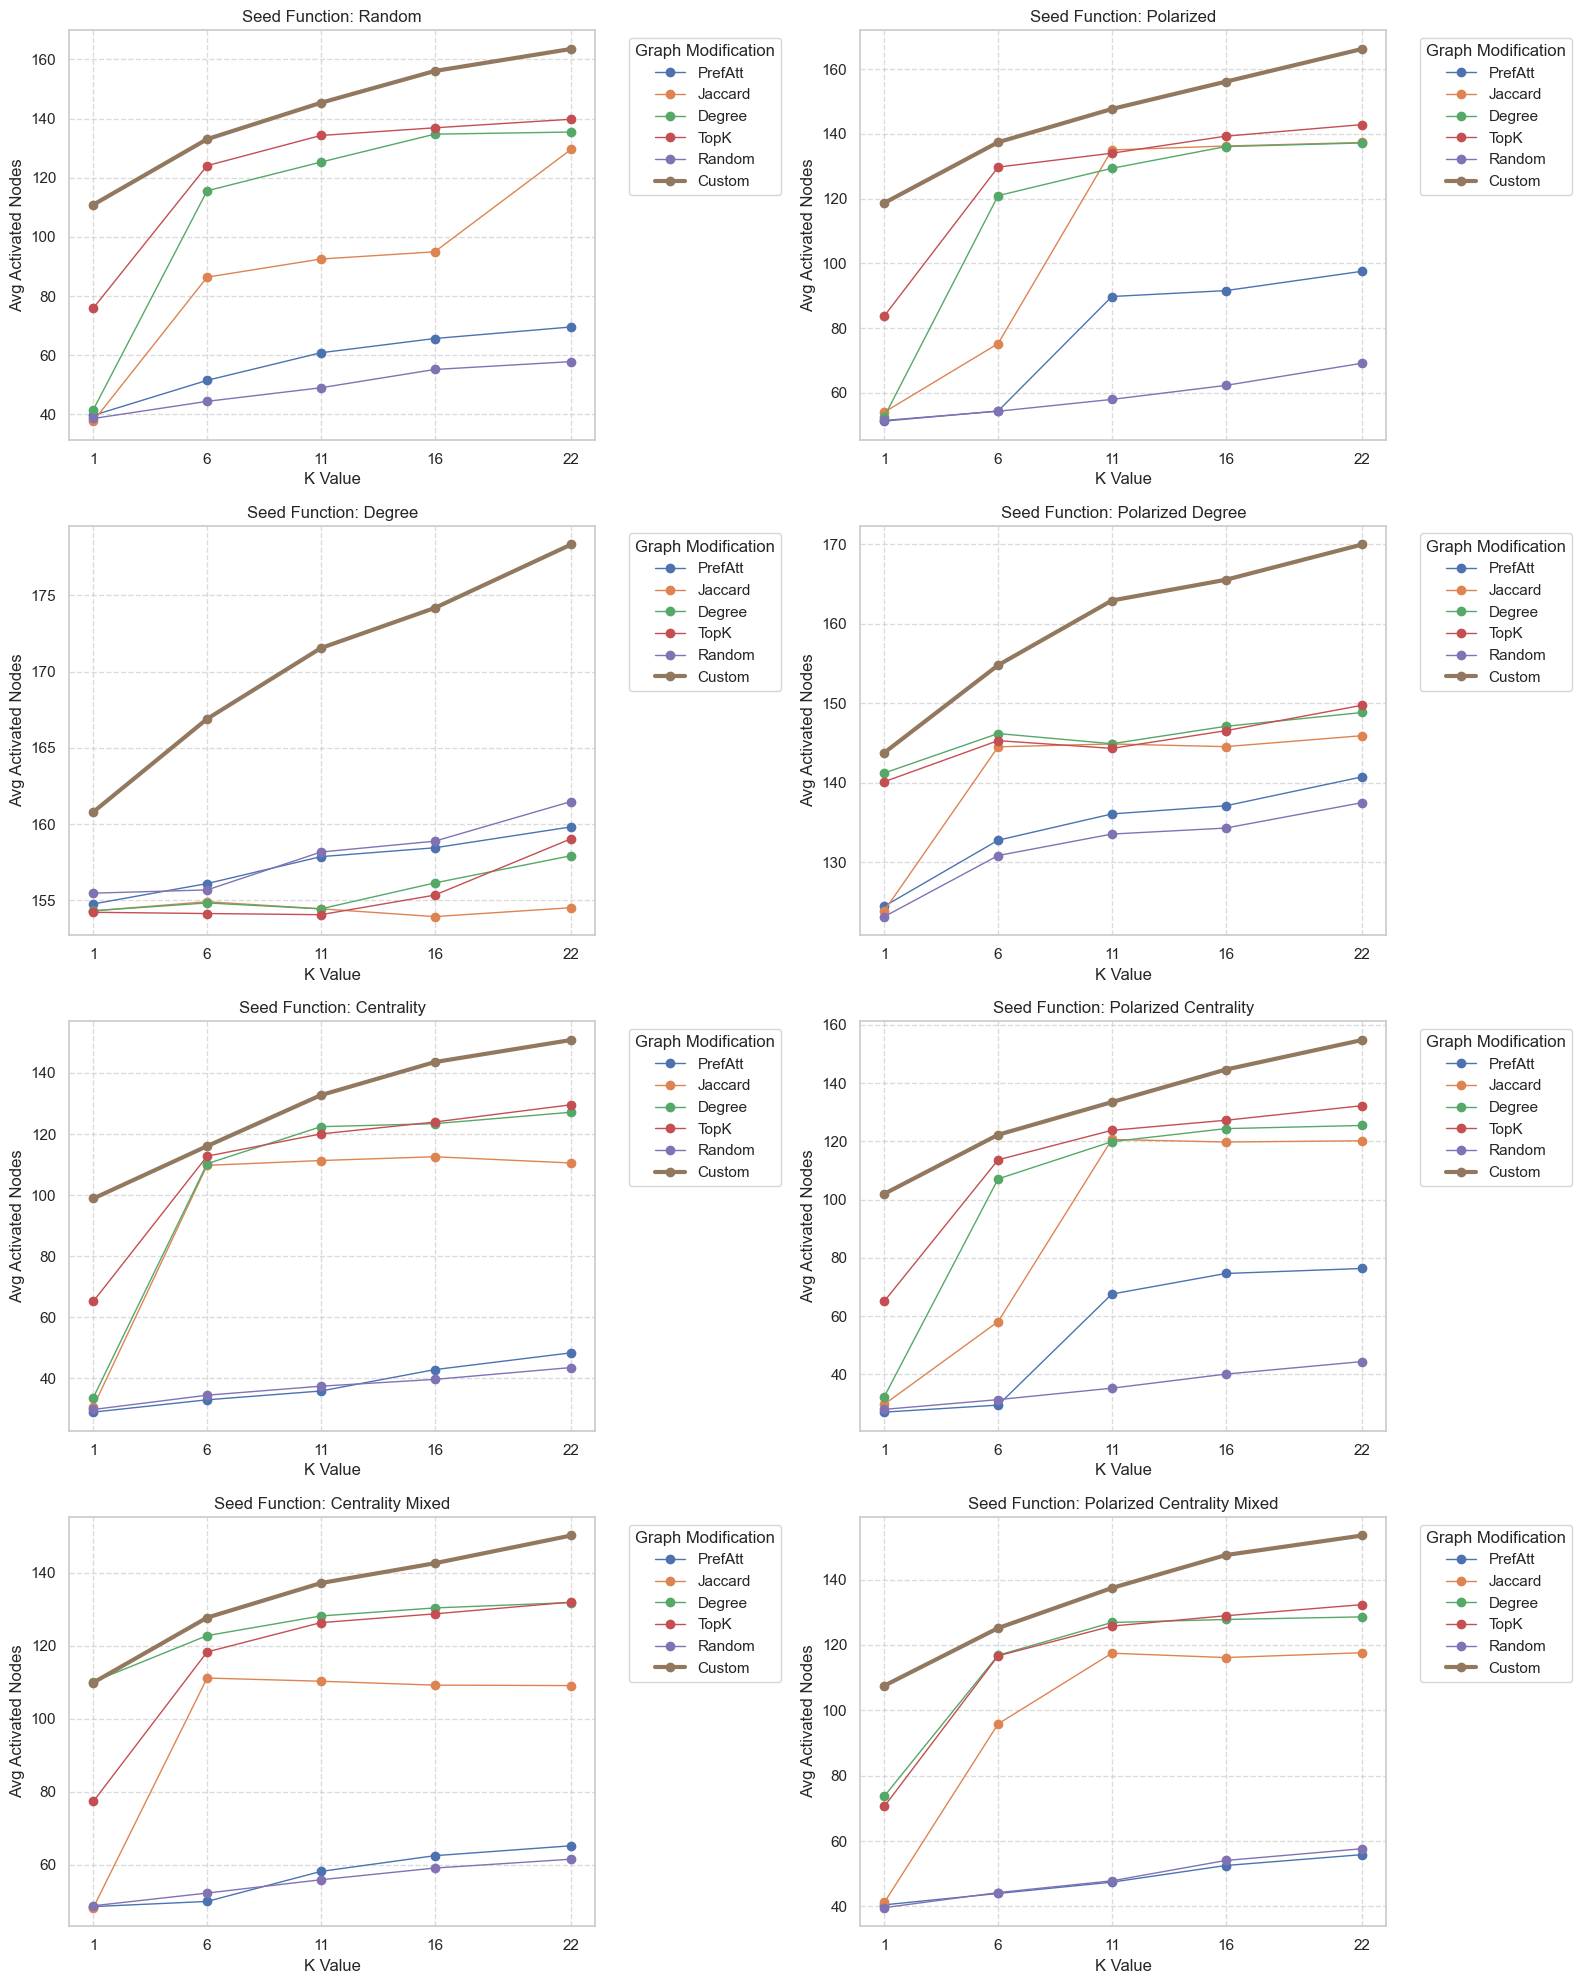

In [ ]:
# Create plots
fig = plot_incremental_results(all_results_df, "Avg Activated Nodes")
plt.show()


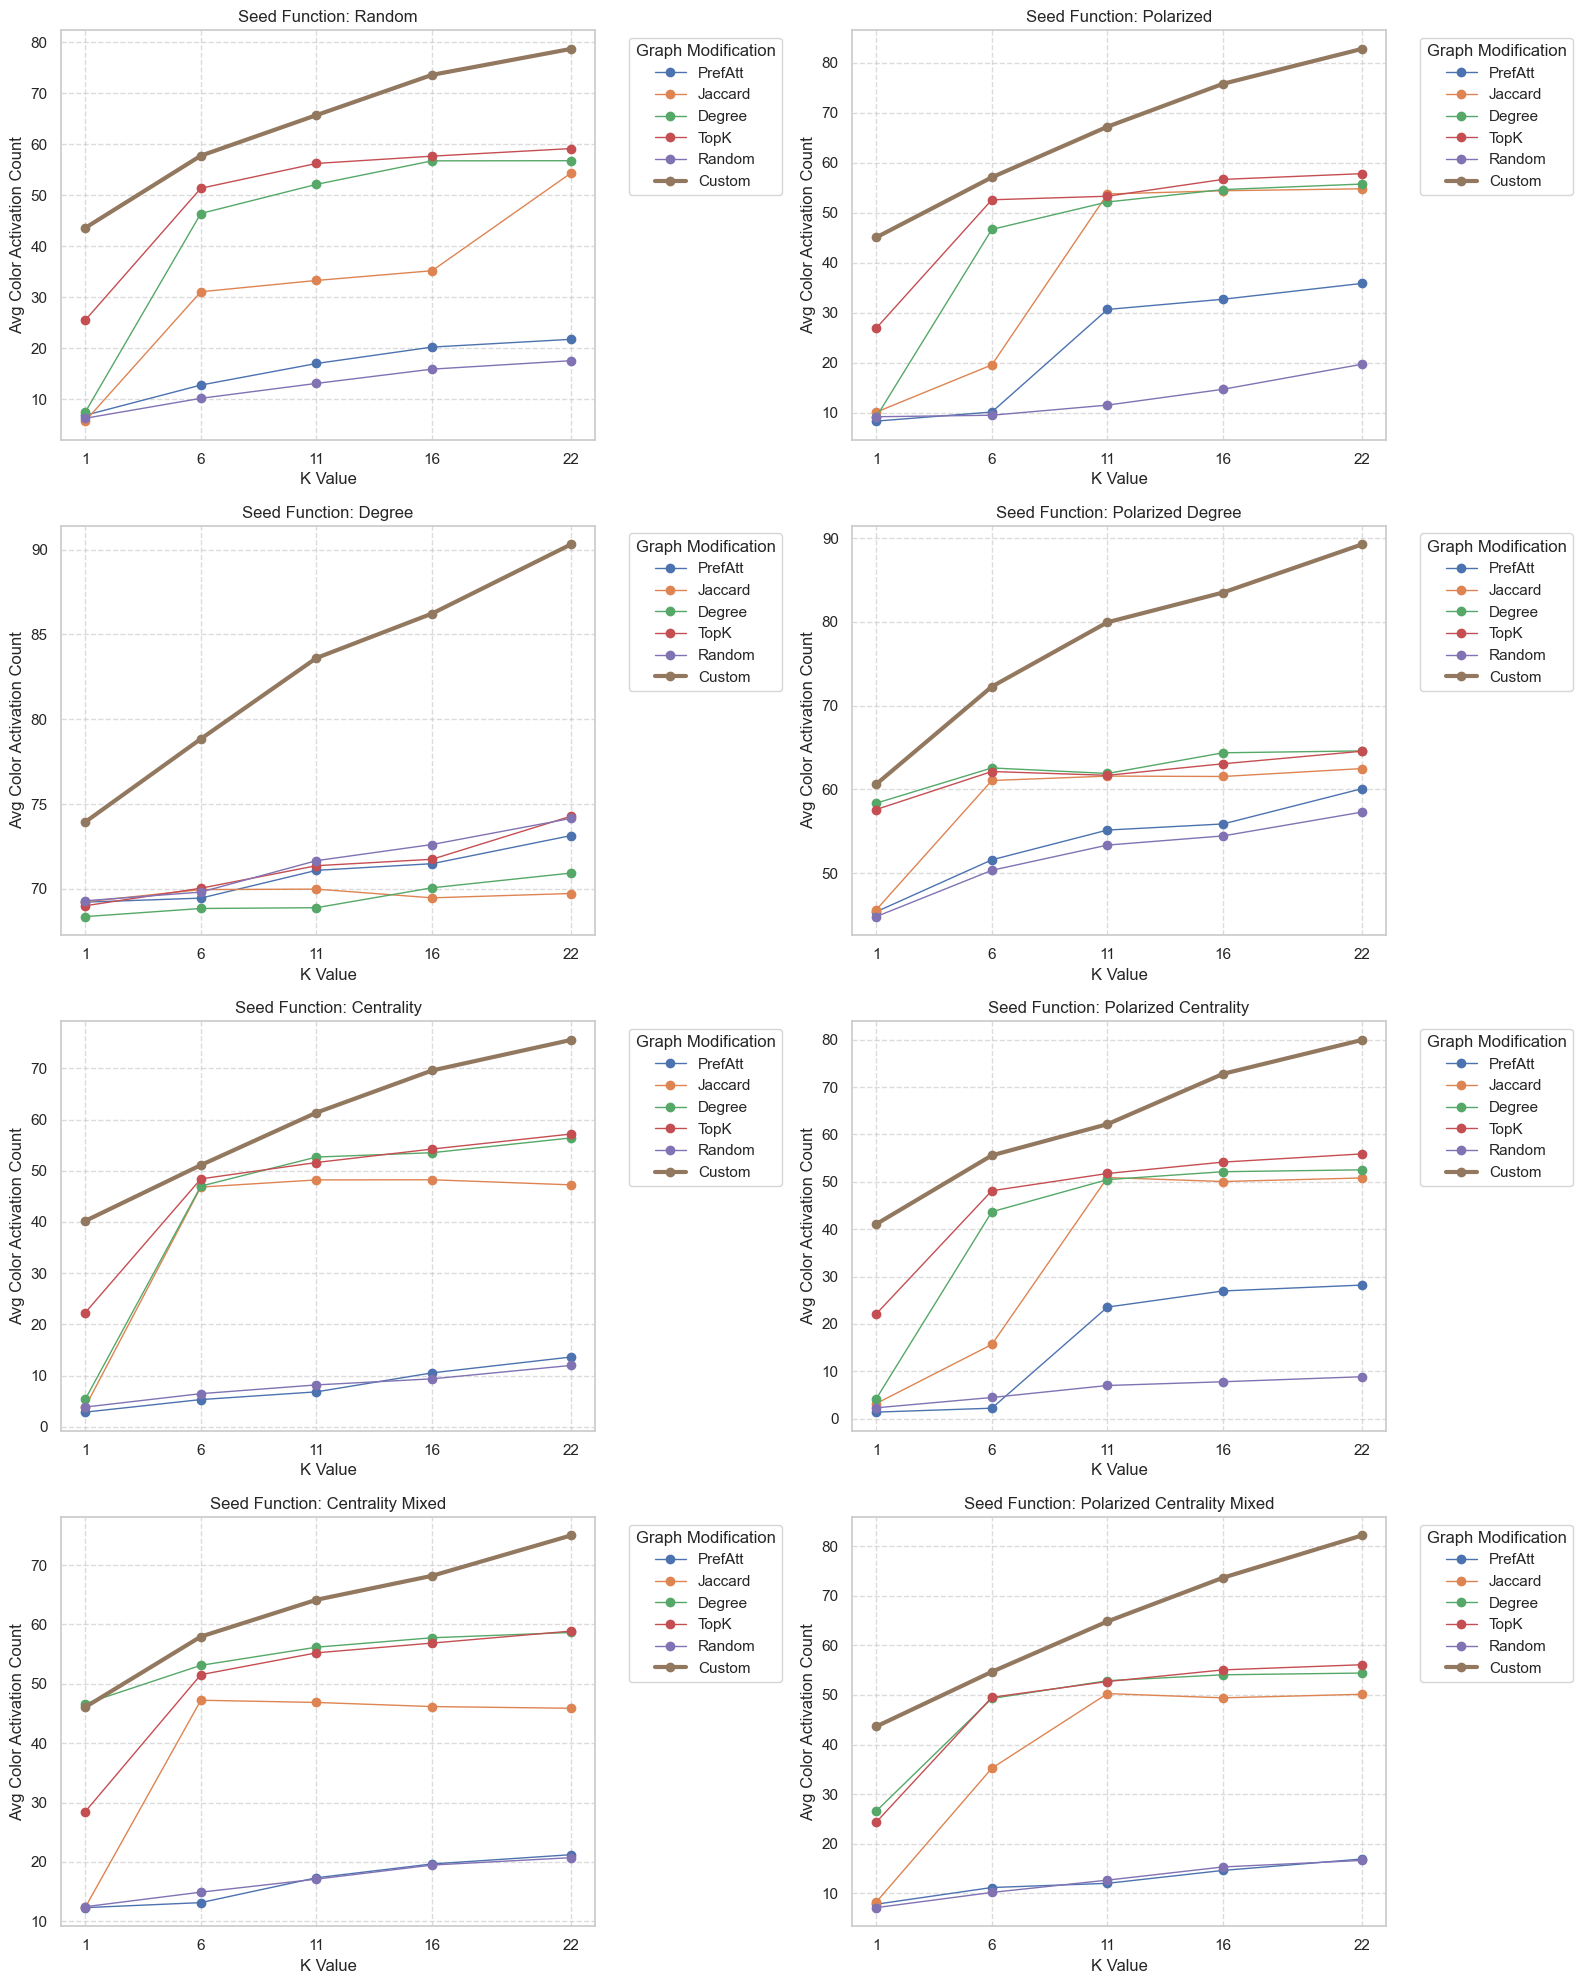

In [ ]:
# Create plots
fig = plot_incremental_results(all_results_df, "Avg Color Activation Count")
plt.show()
